In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from scipy.sparse import csr_matrix
from shutil import copyfile
import operator
import numpy as np
from utility.list_set_util import argsort
import matplotlib
import matplotlib.pyplot as plt
from utility.visualization_utility import create_mat_plot
import seaborn as sns; sns.set()
from utility.math_utility import normalize_mat
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from scipy.sparse import csr_matrix
import os
import tqdm
path = '/mounts/data/proj/asgari/dissertation/datasets/deepbio/taxonomy/ncbi-blast-2.5.0+/bin/'
os.environ['PATH'] += ':'+path
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from utility.math_utility import get_sym_kl_rows, get_borders, normalize_mat, compute_serial_matrix
from nltk import FreqDist
import operator
import pandas as pd
from scipy.spatial.distance import pdist, squareform

%pylab inline
%matplotlib inline 

Populating the interactive namespace from numpy and matplotlib


/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['argsort']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
class BioCPEMarkerAnlaysis:
    
    def __init__(self,fasta_file, matrix_path, feature_file_path, phenotypes, phenotype_mapping, p_value_threshold=0.01, remove_redundants=False):
        self.seq_IDS=FileUtility.read_fasta_sequences_ids(fasta_file)
        self.remove_redundants=remove_redundants
        self.ez_taxa_dict={x.split()[0]:x.split()[1].split(';') for x in FileUtility.load_list('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_id_taxonomy.txt')}
        self.mat=FileUtility.load_sparse_csr(matrix_path)
        self.features=FileUtility.load_list(feature_file_path)
        self.align_markers(p_value_threshold)        
        self.redundant_columns_indentification()
        self.phenotype_mapping=phenotype_mapping
        self.phenotypes=phenotypes

        
    def generate_heatmap(self,filename, pos_label=None, neg_label=None):
        # heatmap anlaysis
        # N markers by M samples
        # self.update_matrix
        # N makrers
        # self.aligned_markers
        
        X_idx_1=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==1 ]
        X_idx_0=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==0 ]
        
        if not pos_label or not neg_label:
            keys=list(self.phenotype_mapping.keys())
            if self.phenotype_mapping[keys[0]] ==1:
                pos_label=keys[0]
                neg_label=keys[1]
            else:
                pos_label=keys[1]
                neg_label=keys[0]
        
        # create and normalize positive and negative matrices
        labels=[pos_label]*len(X_idx_1)+[neg_label]*len(X_idx_0)

        pos_matrix=FM2EXCtvsh.update_matrix[:,X_idx_1]
        pos_matrix=np.log(normalize_mat(pos_matrix,axis=0)*100+1)

        neg_matrix=FM2EXCtvsh.update_matrix[:,X_idx_0]
        neg_matrix=np.log(normalize_mat(neg_matrix,axis=0)*100+1)

        pos_distances=get_sym_kl_rows(pos_matrix.T)
        neg_distances=get_sym_kl_rows(neg_matrix.T)
        
        # create matrix and sort it
        seriated_dist, res_order_pos, res_linkage=compute_serial_matrix(pos_distances,method="complete")
        seriated_dist, res_order_neg, res_linkage=compute_serial_matrix(neg_distances,method="complete")
        column_sorted=np.concatenate([pos_matrix[:,res_order_pos],neg_matrix[:,res_order_neg]],axis=1)
        rows_reverted=column_sorted[::-1,]
        
        # create taxonomy annotation
        taxonomy=[x[1] if x[1] not in ['ZZZNOVEL-','ZZZNOVEL+'] else x[1]+x[0] for x in self.aligned_markers]
        
        fig, ax = plt.subplots(figsize=(40,60)) 
        sns.heatmap(rows_reverted, cbar=True, ax=ax, cmap='Purples',)
        ax.hlines(get_borders(taxonomy), *ax.get_xlim(), colors=['purple'])
        ax.vlines(get_borders(labels), *ax.get_ylim(), label=['u','h'], color='purple',linewidth=2)

        plt.text(0.4,column_sorted.shape[0]+1,labels[0].replace('_','-'), color='purple', fontsize=20)
        for x in get_borders(labels):
            plt.text(x+0.4,column_sorted.shape[0]+1,labels[x].replace('_','-'), color='purple', fontsize=20)

        plt.text(0.5,0,taxonomy[0].replace('_','-'), rotation=0,color='purple', fontsize=10)
        for x in get_borders(taxonomy):
            if 'ZZZ' in taxonomy[x]:
                plt.text(0.5,x,taxonomy[x].replace('_','-').replace('ZZZ',''), rotation=0, color='orangered', fontsize=10)
            else:
                plt.text(0.5,x,taxonomy[x].replace('_','-'), rotation=0, color='purple', fontsize=10)

        ax.axhline(y=0, color='purple',linewidth=5)
        ax.axvline(x=0, color='purple',linewidth=5)
        ax.axhline(y=column_sorted.shape[0], color='purple',linewidth=5)
        ax.axvline(x=column_sorted.shape[1], color='purple',linewidth=5)



        plt.xlabel('Samples', color='purple', fontsize=40)
        plt.ylabel('Sorted Markers', color='purple', fontsize=40)
        ax.grid(True)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(filename+'.pdf', dpi=600 )
        plt.show()
        
    def generate_tree(self):
        font_map={1:15,2:14,3:13,4:12, 5:8,6:7,7:4}
        taxonomy=self.get_pandas_df()['taxonomy'].tolist()
        direction=self.get_pandas_df()['direction'].tolist()
        taxlev=self.get_pandas_df()['taxonomylevel'].tolist()

        logpval=[round(-np.log(x)) for x in FM2EXC.get_pandas_df()['pvalue'].tolist()]


        taxonomy=['.'.join(fix_taxonomy(x).split(';')) for x in taxonomy]
        tax_freq=dict(FreqDist(taxonomy).most_common())
        logpval_frq=[tax_freq[x] for idx,x in enumerate(taxonomy)]

        #taxonomy=['.'.join(x[0:-1] if isGenomeName(x[-1]) else x) for x in taxonomy]
        annot=['\t'.join([taxonomy[idx].split('.')[-1],'annotation_background_color',('r' if x=='+' else ('b' if x=='-' else 'g'))])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>5]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'annotation_background_color','w'])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))==5]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'annotation',taxonomy[idx].split('.')[-1]])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>5]

        ## OUTER RINGS
        annot=annot+['\t'.join([taxonomy[idx].split('.')[1],'annotation',taxonomy[idx].split('.')[1]])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>1]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[1],'annotation_rotation',str(1)])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>1]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[1],'annotation_font_size',str(9)])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>1 ]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[1],'annotation_background_color','#eedbfc'])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>1]

        ## Clades
        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'clade_marker_size',str(logpval_frq[idx])])  for idx, x in enumerate(direction)  if len(taxonomy[idx].split('.'))>5 ]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'clade_marker_edge_width',str(logpval[idx])])  for idx, x in enumerate(direction)  if len(taxonomy[idx].split('.'))>5 ]

        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'annotation_rotation',str(1)])  for idx, x in enumerate(direction)  if len(taxonomy[idx].split('.'))>5]
        annot=annot+['\t'.join([taxonomy[idx].split('.')[-1],'annotation_font_size',str(font_map[taxlev[idx]])])  for idx, x in enumerate(direction) if len(taxonomy[idx].split('.'))>5 ]
        annot=annot+['annotation_background_offset\t0.5']
        annot=annot+['clade_marker_edge_color\t#4f1a49']
        annot=annot+['branch_color\t#4f1a49']
        annot=annot+['annotation_background_separation\t-0.01']
        annot=annot+['annotation_background_width\t0.2']


        #https://bitbucket.org/nsegata/graphlan/src/default/readme.txt?fileviewer=file-view-default
        #asgari@epsilon1:/mounts/data/proj/asgari/dissertation/libraries/graphlan$ python graphlan_annotate.py --annot ../annot.txt ../test.txt  ../new.xml
        #asgari@epsilon1:/mounts/data/proj/asgari/dissertation/libraries/graphlan$ python graphlan.py ../new.xml image_name.pdf --dpi 1000 --size 15
        taxonomy=[x for x in taxonomy if len(x.split('.'))>5]
        FileUtility.save_list('/mounts/data/proj/asgari/dissertation/libraries/test.txt',taxonomy)
        FileUtility.save_list('/mounts/data/proj/asgari/dissertation/libraries/annot.txt',annot)

    def refine_ez_taxonomy(self, record):
        record=record.split(';')        
        new_list=[]
        for z in record:
            if not BioCPEMarkerAnlaysis.isGenomeName(z):
                new_list.append(z)
            else:
                return ';'.join(new_list)
        return ';'.join(new_list)
                    
    def get_pandas_df(self):
        res=self.finalize_the_results()
        idx2col={0:'taxonomy',1:'marker',2:'direction',3:'taxonomylevel',4:'nummarkers',5:'pvalue'}
        table={'taxonomy':[],'marker':[],'direction':[],'taxonomylevel':[],'nummarkers':[],'pvalue':[]}
        for row in res:
            for idx, val in enumerate(row):
                table[idx2col[idx]].append(val)
        return pd.DataFrame(data=table,columns=['direction', 'taxonomy','marker','pvalue','nummarkers','taxonomylevel'])

    def finalize_the_results(self):
        results=self.extract_results()
        final_results=[]
        for x in results:
            if len(x)>1:
                final_results.append(BioCPEMarkerAnlaysis.find_best_record(x))
            else:
                x=x[0]
                taxa=x[1][0:-1]
                seq=x[0]
                d=x[1][-1]
                length=len(taxa.split(';'))-np.sum([1 if BioCPEMarkerAnlaysis.isGenomeName(name) else 0 for name in taxa.split(';')])
                final_results.append([taxa,seq,d,length,1,x[2]])
        candidates=sorted(final_results, key=lambda element: (element[2],-element[3],element[5],element[4]))
        return candidates
        
    def extract_results(self):
        results=[]
        for group in self.equiv_classes:
            results.append([self.aligned_markers[x] for x in group])
        return results
            
    def update_matrix_by_markers(self):
        '''
            called by align_markers
        '''
        new_matrix=[]
        for feature, taxnomy, pvalue in self.aligned_markers:
            column=self.features.index(feature)
            new_matrix.append(self.mat[:,column].toarray().T[0].tolist())
        new_matrix=np.array(new_matrix)
        self.update_matrix=new_matrix

    @staticmethod
    def find_best_record(records):
        candiates=[(x[0],x[1],x[2],-len(x[1].split(';'))) for x in records]
        taxa_freq=FreqDist([y[1] for y in candiates]).most_common()
        final=[]
        for taxa, freq in taxa_freq:
            min_idx = np.argmin([rec[2] for rec in records if rec[1]==taxa])
            rep_marker=[rec[0] for rec in records if rec[1]==taxa][min_idx]
            pval=np.median([rec[2] for rec in records if rec[1]==taxa])
            direction=taxa[-1]
            taxlevel=len(taxa[0:-1].split(';'))-np.sum([1 if BioCPEMarkerAnlaysis.isGenomeName(name) else 0 for name in taxa[0:-1].split(';')])
            final.append([taxa[0:-1],rep_marker,direction, taxlevel, freq,pval])
        candidates=sorted(final, key=lambda element: (-element[3],element[5],element[4]))
        return candidates[0]

    @staticmethod
    def find_equiv_classes(list_of_pairs):
        found_list=[]
        for x,y in list_of_pairs:
            if found_list==[]:
                found_list.append(set([x,y]))
            else:
                idx_to_add=-1
                idx_to_add_list=[]
                for idx,group in enumerate(found_list):
                    if x in group or y in group:
                        idx_to_add=idx
                        idx_to_add_list.append(idx)
                if idx_to_add==-1:
                    found_list.append(set([x,y]))
                else:
                    res=set([x,y])
                    for st in idx_to_add_list:
                        res=res.union(found_list[st])
                    for i in idx_to_add_list[::-1]:
                        found_list.remove(found_list[i])
                    found_list.append(res)
        return found_list
    
    @staticmethod
    def isGenomeName(inputString):
        return np.sum([1 if char.isdigit() else 0 for char in inputString])/np.sum([1 if char.isalpha() else 0 for char in inputString])>0.8

    def lowest_certain_level(self,results):
        
        levels_id={'Superkingdom':1,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}
        species=set([x[0][levels_id['species']] for x in results])
        genuses=set([x[0][levels_id['genus']] for x in results])
        families=set([x[0][levels_id['family']] for x in results])
        orders=set([x[0][levels_id['order']] for x in results])
        classes=set([x[0][levels_id['class']] for x in results])
        phylums=set([x[0][levels_id['phylum']] for x in results])
        Superkingdoms=set([x[0][levels_id['Superkingdom']] for x in results])

        if len(species)==1:
            return ';'.join(results[0][0])
        elif len(genuses)==1:
            return ';'.join(results[0][0][0:6])
        elif len(families)==1:
            return ';'.join(results[0][0][0:5])
        if len(orders)==1:
            return ';'.join(results[0][0][0:4])
        elif len(classes)==1:
            return ';'.join(results[0][0][0:3]) 
        elif len(phylums)==1:
            return ';'.join(results[0][0][0:2]) 
        elif len(Superkingdoms)==1:
            return ';'.join(results[0][0][0:1]) 
        else:
            return False

    
    
    def redundant_columns_indentification(self):
        #self.list_of_pairs=np.argwhere(distances<np.percentile(flatten_distances, 5, axis=0)).tolist()
        if self.remove_redundants:
            distances=get_sym_kl_rows(self.update_matrix)
            flatten_distances=distances.flatten()
            self.list_of_pairs=np.argwhere(distances==0).tolist()
            self.equiv_classes=BioCPEMarkerAnlaysis.find_equiv_classes(self.list_of_pairs)
        else:
            self.list_of_pairs=[(i,i) for i in range(self.update_matrix.shape[0])]
            self.equiv_classes=FastaMarkers2Excall.find_equiv_classes(self.list_of_pairs)
            
        
    def align_markers(self,p_value_threshold):
        final_results=[]
        for idx, (seq, description) in tqdm.tqdm(self.seq_IDS.items()):
            pval=float(description.split(':')[1])
            if pval<=p_value_threshold:
                FileUtility.create_fasta_file('temp.fasta',[seq],['temp'])
                blastx_cline=NcbiblastnCommandline(query='temp.fasta', db="/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_qiime_full.fasta", evalue=0.001, outfmt=5, out="temp.xml")
                blastx_cline()
                f=open("temp.xml",'r')
                blast_records = NCBIXML.parse(f)
                flag=False
                score=-1
                alignment_length=-1
                results=[]
                for blast_record in blast_records:
                    for alignment in blast_record.alignments:
                        for hsp in alignment.hsps:
                            if not flag and score==-1:
                                score=hsp.score
                                alignment_length=hsp.align_length
                                flag=True
                            if hsp.score >= score and hsp.align_length>=alignment_length and 'Eukarya' not in self.ez_taxa_dict[alignment.hit_id]:
                                results.append((self.ez_taxa_dict[alignment.hit_id],hsp.expect))
                if len(results)>0:
                    res=self.lowest_certain_level(results)
                    if res:
                        final_results.append((seq,self.refine_ez_taxonomy(res)+idx[-1],pval))
                    else:
                        final_results.append((seq,'ZZZNOVEL'+idx[-1],pval))
                else:
                    final_results.append((seq,'ZZZNOVEL'+idx[-1],pval))

        # sorted markers by the taxonomy information of the last certain level
        self.aligned_markers=sorted(final_results, key=operator.itemgetter(1), reverse=False)
        self.min_p_value=p_value_threshold
        self.update_matrix_by_markers()

In [3]:
fasta_file='/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/ra/markers/unt_healthy_chi2_relative.fasta'
matrix_path='../../16S_datasets/ra/rep/ra_unique_50000_cpe_-1.npz'
feature_file_path='../../16S_datasets/ra/rep/ra_unique_50000_cpe_-1_features'
phenotypes=FileUtility.load_list('../../16S_datasets/ra/rep/labels.txt')
phenotype_mapping={'untreated_RA':1,'healthy':0}
FM2EXCtvsh=BioCPEMarkerAnlaysis(fasta_file, matrix_path, feature_file_path, phenotypes, phenotype_mapping, p_value_threshold=0.01, remove_redundants=True)

100%|██████████| 1335/1335 [01:01<00:00, 21.54it/s]


In [4]:
def generate_heatmap(self,filename, pos_label=None, neg_label=None):
    # heatmap anlaysis
    # N markers by M samples
    # self.update_matrix
    # N makrers
    # self.aligned_markers
    plt.rc('text', usetex = True)
    X_idx_1=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==1 ]
    X_idx_0=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==0 ]

    if not pos_label or not neg_label:
        keys=list(self.phenotype_mapping.keys())
        if self.phenotype_mapping[keys[0]] ==1:
            pos_label=keys[0]
            neg_label=keys[1]
        else:
            pos_label=keys[1]
            neg_label=keys[0]

    # create and normalize positive and negative matrices
    labels=[pos_label]*len(X_idx_1)+[neg_label]*len(X_idx_0)

    pos_matrix=FM2EXCtvsh.update_matrix[:,X_idx_1]
    pos_matrix=np.log(normalize_mat(pos_matrix,axis=0)*100+1)

    neg_matrix=FM2EXCtvsh.update_matrix[:,X_idx_0]
    neg_matrix=np.log(normalize_mat(neg_matrix,axis=0)*100+1)

    pos_distances=get_sym_kl_rows(pos_matrix.T)
    neg_distances=get_sym_kl_rows(neg_matrix.T)

    # create matrix and sort it
    seriated_dist, res_order_pos, res_linkage=compute_serial_matrix(pos_distances,method="complete")
    seriated_dist, res_order_neg, res_linkage=compute_serial_matrix(neg_distances,method="complete")
    column_sorted=np.concatenate([pos_matrix[:,res_order_pos],neg_matrix[:,res_order_neg]],axis=1)
    

    # create taxonomy annotation
    taxonomy=[x[1] if x[1] not in ['ZZZNOVEL-','ZZZNOVEL+'] else x[1] for x in self.aligned_markers]
    taxonomy_orig=taxonomy
    
    y_labels=[x[0] for x in self.aligned_markers]
    
    rows=get_borders(taxonomy)
    rows=[0]+rows
    y_borders=[]
    for idx,r in enumerate(rows):
        column_sorted=np.insert(column_sorted, r+idx, np.array([np.NaN]*column_sorted.shape[1]), 0)  
        y_borders.append(r+idx)
        y_labels.insert(r+idx,'$\\uparrow$')
        taxonomy.insert(r+idx,taxonomy[r+idx])
    
    rows_reverted=column_sorted[::-1,]
    
    fig, ax = plt.subplots(figsize=(40,60)) 
    sns.set_style({'axes.facecolor': 'black','grid.color': 'black'})
    sns.heatmap(rows_reverted, cbar=True, ax=ax, cmap='coolwarm',yticklabels=y_labels[::-1])
    #sns.heatmap(rows_reverted, mask=(rows_reverted==-1), cbar=False, linecolor="black")
    ax.hlines(y_borders, *ax.get_xlim(), colors=['black'],linewidth=2)
    ax.vlines(get_borders(labels), *ax.get_ylim(), label=['u','h'], color='black',linewidth=5)

    plt.text(0.4,rows_reverted.shape[0]+1,labels[0].replace('_','-'), color='purple', fontsize=20, fontweight='bold')
    for x in get_borders(labels):
        plt.text(x+0.4,rows_reverted.shape[0]+1,labels[x].replace('_','-'), color='purple', fontsize=20, fontweight='bold')

    if 'ZZZ' in taxonomy[0]:
        plt.text(0.5,0.1,taxonomy[0].replace('_','-').replace('ZZZ',''), rotation=0, color='orangered', fontsize=12,fontweight='bold')
    else:
        plt.text(0.5,0.1,taxonomy[0].replace('_','-'), rotation=0, color='white', fontsize=10, fontweight='bold')
    for x in y_borders:
        if 'ZZZ' in taxonomy[x]:
            plt.text(0.5,x+0.1,taxonomy[x].replace('_','-').replace('ZZZ',''), rotation=0, color='orangered', fontsize=12,fontweight='bold')
        else:
            plt.text(0.5,x+0.1,taxonomy[x].replace('_','-'), rotation=0, color='white', fontsize=10, fontweight='bold')

    ax.axhline(y=0, color='black',linewidth=5)
    ax.axvline(x=0, color='black',linewidth=5)
    ax.axhline(y=rows_reverted.shape[0], color='black',linewidth=5)
    ax.axvline(x=rows_reverted.shape[1], color='black',linewidth=5)



    plt.xlabel('Samples', color='purple', fontsize=40)
    plt.ylabel('Sorted Markers', color='purple', fontsize=40)
    ax.grid(True)
    plt.xticks([])
    plt.tight_layout()
    #plt.yticks([])
    plt.savefig(filename+'.pdf', dpi=500 , bbox_inches='tight',pad_inches=1)
    plt.show()

In [32]:
def generate_heatmap(self,filename, pos_label=None, neg_label=None):
    # heatmap anlaysis
    # N markers by M samples
    # self.update_matrix
    # N makrers
    # self.aligned_markers
    plt.rc('text', usetex = True)
    X_idx_1=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==1 ]
    X_idx_0=[idx for idx, v in enumerate(self.phenotypes) if v in self.phenotype_mapping and self.phenotype_mapping[v]==0 ]

    if not pos_label or not neg_label:
        keys=list(self.phenotype_mapping.keys())
        if self.phenotype_mapping[keys[0]] ==1:
            pos_label=keys[0]
            neg_label=keys[1]
        else:
            pos_label=keys[1]
            neg_label=keys[0]

    # create and normalize positive and negative matrices
    labels=[pos_label]*len(X_idx_1)+[neg_label]*len(X_idx_0)

    pos_matrix=FM2EXCtvsh.update_matrix[:,X_idx_1]
    pos_single_hits=list(zip(*np.where(pos_matrix==1)))
    pos_matrix=np.log(normalize_mat(pos_matrix,axis=0)*100+1)

    neg_matrix=FM2EXCtvsh.update_matrix[:,X_idx_0]
    neg_single_hits=list(zip(*np.where(neg_matrix==1)))
    neg_matrix=np.log(normalize_mat(neg_matrix,axis=0)*100+1)

    pos_distances=get_sym_kl_rows(pos_matrix.T)
    neg_distances=get_sym_kl_rows(neg_matrix.T)

    # create matrix and sort it
    seriated_dist, res_order_pos, res_linkage=compute_serial_matrix(pos_distances,method="complete")
    seriated_dist, res_order_neg, res_linkage=compute_serial_matrix(neg_distances,method="complete")
    
    ##### single hits
    pos_dict={x:idx for idx,x in  enumerate(res_order_pos)}
    neg_dict={x:idx for idx,x in  enumerate(res_order_neg)}
    pos_single_hits=[(x,pos_dict[y]) for x,y in pos_single_hits]
    neg_single_hits=[(x,neg_dict[y]+len(X_idx_1)) for x,y in neg_single_hits]
    single_hits=pos_single_hits+neg_single_hits
    #[(x,y+) for x,y in list(zip(*np.where(neg_matrix==1)))]
    column_sorted=np.concatenate([pos_matrix[:,res_order_pos],neg_matrix[:,res_order_neg]],axis=1)
    
    # single hits
    #for x,y in single_hits:
    #    column_sorted[x,y]=10
    
    # create taxonomy annotation
    taxonomy=[x[1] if x[1] not in ['ZZZNOVEL-','ZZZNOVEL+'] else x[1] for x in self.aligned_markers]
    taxonomy_orig=taxonomy
    
    y_labels=[x[0] for x in self.aligned_markers]
    
    rows=get_borders(taxonomy)
    rows=[0]+rows
    y_borders=[]
    map_y={i:i for i in range(len(taxonomy))}
    for idx,r in enumerate(rows):
        column_sorted=np.insert(column_sorted, r+idx, np.array([np.NaN]*column_sorted.shape[1]), 0)  
        y_borders.append(r+idx)
        y_labels.insert(r+idx,'$\\uparrow$')
        taxonomy.insert(r+idx,taxonomy[r+idx])
        map_y={k:((v+1) if k>=r else v) for k,v in map_y.items() }
    #keys=list(map_y.keys())
    #keys.sort()
    #for k in keys:
    #    print(k,map_y[k])
    rows_reverted=column_sorted[::-1,]
    
    fig, ax = plt.subplots(figsize=(40,60)) 
    sns.set_style({'axes.facecolor': 'black','grid.color': 'black','axes.facecolor': 'black','figure.facecolor': 'black'})
    sns.heatmap(rows_reverted, cbar=True, ax=ax, cmap='coolwarm',yticklabels=y_labels[::-1])
    #sns.heatmap(rows_reverted, mask=(rows_reverted==-1), cbar=False, linecolor="black")
    ax.hlines(y_borders, *ax.get_xlim(), colors=['black'],linewidth=2)
    ax.vlines(get_borders(labels), *ax.get_ylim(), label=['u','h'], color='black',linewidth=5)

    plt.text(0.4,rows_reverted.shape[0]+1,labels[0].replace('_','-'), color='purple', fontsize=20, fontweight='bold')
    for x in get_borders(labels):
        plt.text(x+0.4,rows_reverted.shape[0]+1,labels[x].replace('_','-'), color='purple', fontsize=20, fontweight='bold')

    for x,y in single_hits:
        plt.text(y+0.2,map_y[x]-0.2,'*', color='white', fontsize=15, fontweight='bold')
    
    if 'ZZZ' in taxonomy[0]:
        plt.text(0.5,0.1,taxonomy[0].replace('_','-').replace('ZZZ',''), rotation=0, color='orangered', fontsize=12,fontweight='bold')
    else:
        plt.text(0.5,0.1,taxonomy[0].replace('_','-'), rotation=0, color='white', fontsize=10, fontweight='bold')
    for x in y_borders:
        if 'ZZZ' in taxonomy[x]:
            plt.text(0.5,x+0.1,taxonomy[x].replace('_','-').replace('ZZZ',''), rotation=0, color='orangered', fontsize=12,fontweight='bold')
        else:
            plt.text(0.5,x+0.1,taxonomy[x].replace('_','-'), rotation=0, color='white', fontsize=10, fontweight='bold')

    ax.axhline(y=0, color='black',linewidth=5)
    ax.axvline(x=0, color='black',linewidth=5)
    ax.axhline(y=rows_reverted.shape[0], color='black',linewidth=5)
    ax.axvline(x=rows_reverted.shape[1], color='black',linewidth=5)

    #sns.clustermap(df, metric="correlation", method="single",

    plt.xlabel('Samples', color='purple', fontsize=40)
    plt.ylabel('Sorted markers by taxonomy', color='purple', fontsize=40)
    ax.grid(True)
    plt.xticks([])
    plt.tight_layout()
    #plt.yticks([])
    plt.savefig(filename+'.pdf', dpi=500 , bbox_inches='tight',pad_inches=1)
    plt.show()
    

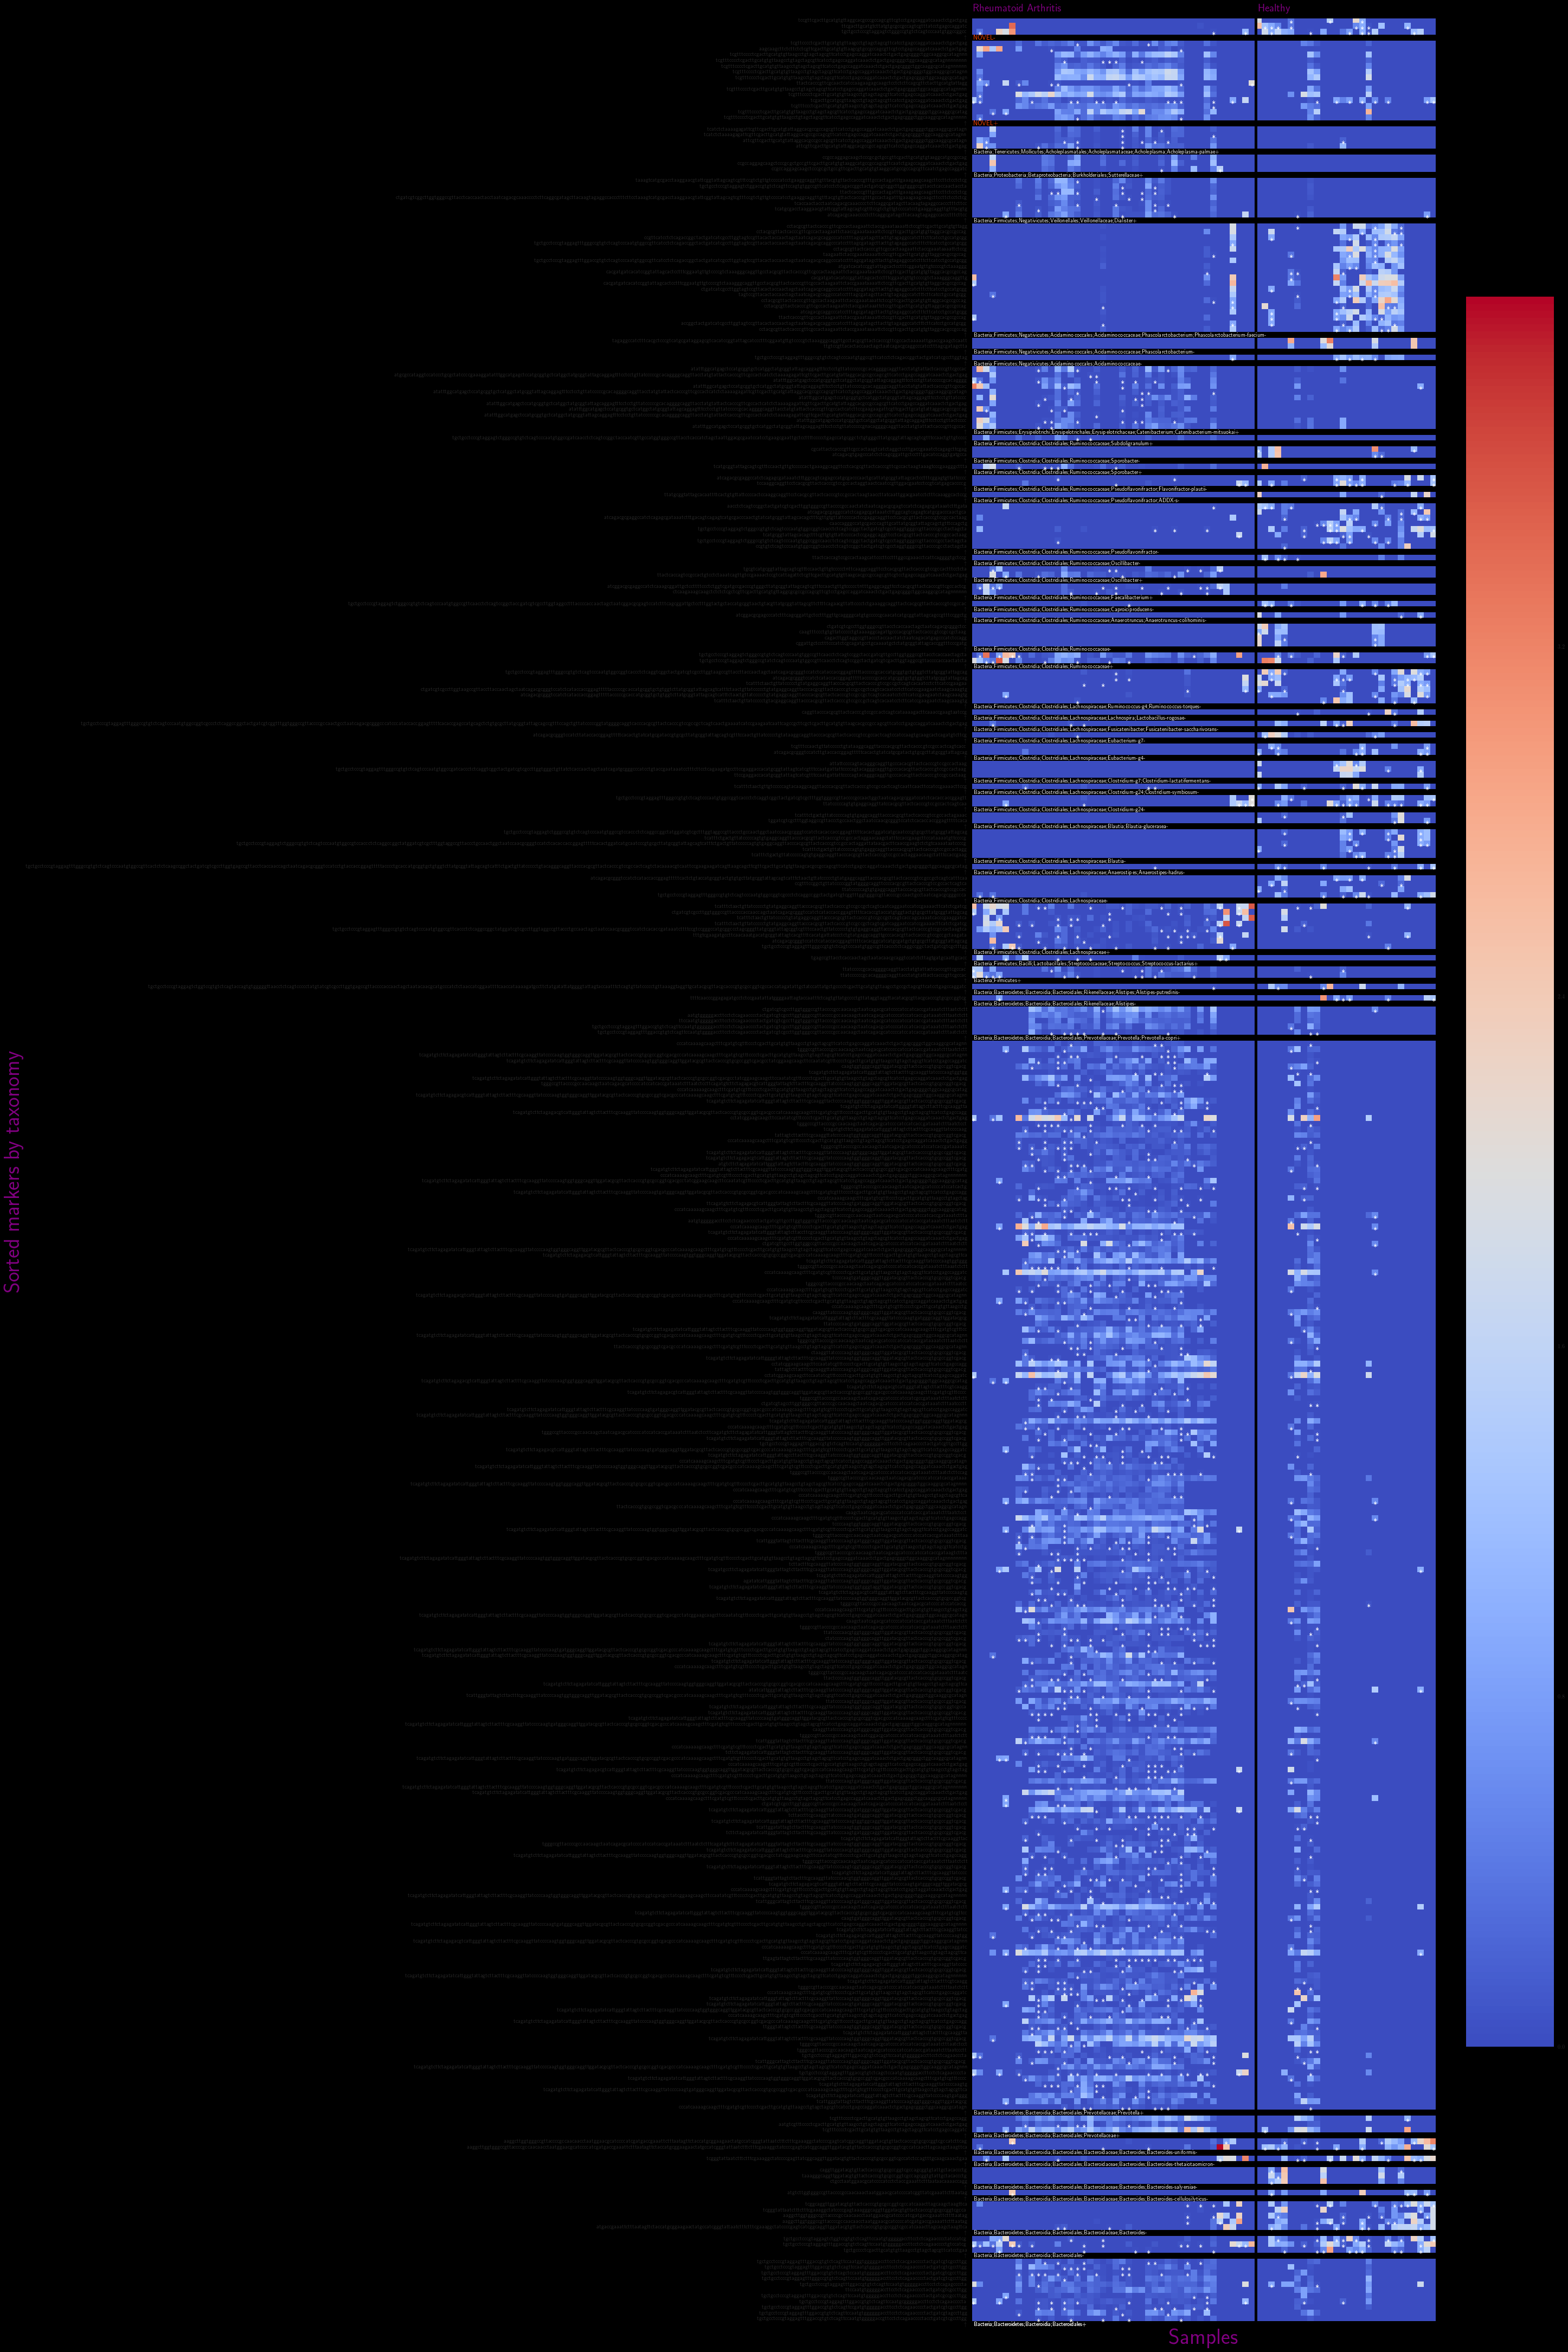

In [33]:
generate_heatmap(FM2EXCtvsh, 'new_heatmap', pos_label='Rheumatoid Arthritis', neg_label='Healthy')